# Importing the Modules/Libraries

In [9]:
!pip install opencv-python

   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/38.8 MB 812.7 kB/s eta 0:00:48
   ---------------------------------------- 0.1/38.8 MB 751.6 kB/s eta 0:00:52
   ---------------------------------------- 0.2/38.8 MB 833.5 kB/s eta 0:00:47
   ---------------------------------------- 0.2/38.8 MB 794.9 kB/s eta 0:00:49
   ---------------------------------------- 0.3/38.8 MB 1.1 MB/s eta 0:00:36
   ---------------------------------------- 0.4/38.8 MB 1.2 MB/s eta 0:00:31
    --------------------------------------- 0.5/38.8 MB 1.4 MB/s eta 0:00:27
    --------------------------------------- 0.6/38.8 MB 1.5 MB/s eta 0:00:26
    --------------------------------------- 0.7/38.8 MB 1.6 MB/s eta 0:00:25
    --------------------------------------- 0.9/38.8 MB 1.8 MB/s eta 0:00:21
   - -------


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Load the Dataset

In [4]:
# Define dataset paths
base_dir = r"C:\Users\sehaj\Documents\Northeastern classes\Neural Network\human-emotion-detection\Emotions Dataset"
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Print the number of images in each folder
for category in ['sad', 'happy', 'angry']:
    train_count = len(os.listdir(os.path.join(train_dir, category)))
    test_count = len(os.listdir(os.path.join(test_dir, category)))
    print(f"Train {category}: {train_count} images")
    print(f"Test {category}: {test_count} images")


Train sad: 2255 images
Test sad: 757 images
Train happy: 3019 images
Test happy: 1006 images
Train angry: 1525 images
Test angry: 515 images


# Exploratory Data Analysis

### Visualize Class Distribution

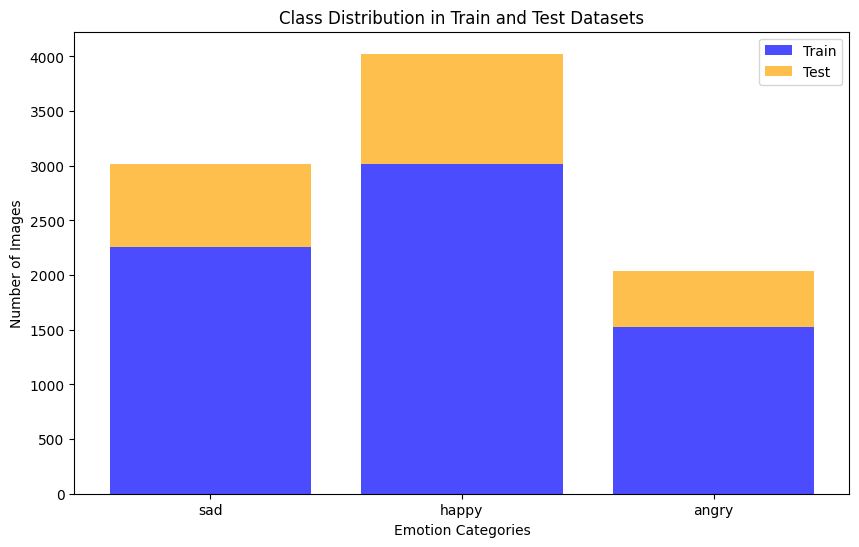

In [5]:
categories = ['sad', 'happy', 'angry']
train_counts = [2255, 3019, 1525]
test_counts = [757, 1006, 515]

plt.figure(figsize=(10, 6))
plt.bar(categories, train_counts, color='blue', alpha=0.7, label='Train')
plt.bar(categories, test_counts, color='orange', alpha=0.7, label='Test', bottom=train_counts)
plt.title('Class Distribution in Train and Test Datasets')
plt.ylabel('Number of Images')
plt.xlabel('Emotion Categories')
plt.legend()
plt.show()

### Visualize Sample Images

Samples from category: sad


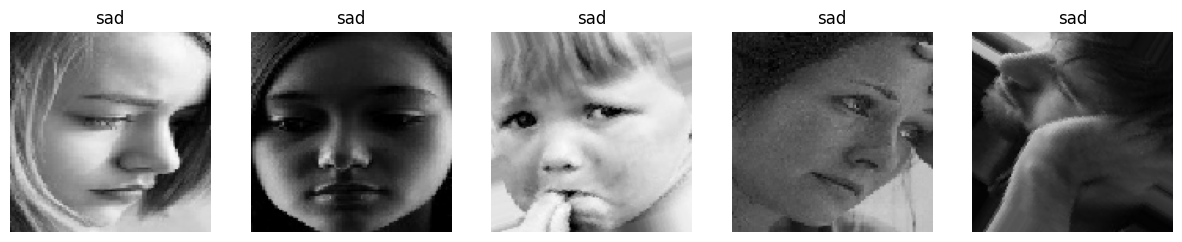

Samples from category: happy


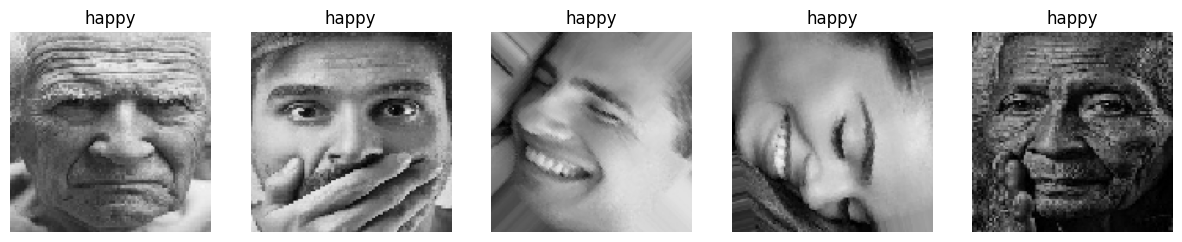

Samples from category: angry


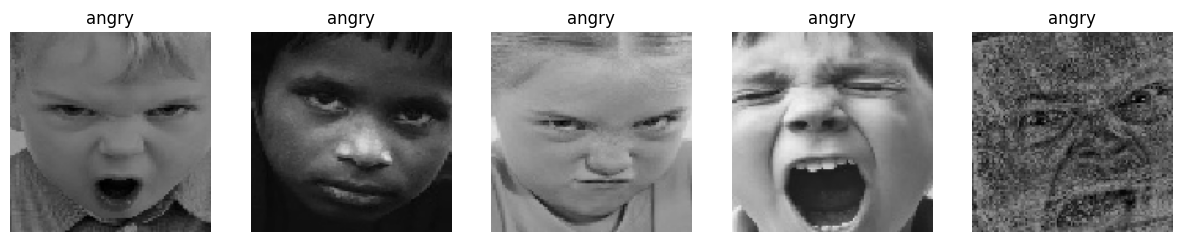

In [7]:
def display_samples(directory, category, num_images=5):
    folder_path = os.path.join(directory, category)
    images = random.sample(os.listdir(folder_path), num_images)

    plt.figure(figsize=(15, 10))
    for i, image_name in enumerate(images):
        img = load_img(os.path.join(folder_path, image_name), target_size=(128, 128))
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(category)
        plt.axis('off')
    plt.show()

for category in categories:
    print(f"Samples from category: {category}")
    display_samples(train_dir, category)


### Inspect Image Properties

In [11]:
def inspect_images(directory, category):
    folder_path = os.path.join(directory, category)
    file_sizes = []
    dimensions = []

    for file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, file)
        img = cv2.imread(img_path)

        if img is not None:
            file_sizes.append(os.path.getsize(img_path))
            dimensions.append(img.shape)

    print(f"Category: {category}")
    print(f" - Average File Size: {np.mean(file_sizes) / 1024:.2f} KB")
    print(f" - Average Dimensions: {np.mean([dim[0] for dim in dimensions]):.2f} x {np.mean([dim[1] for dim in dimensions]):.2f}")
    print(f" - Color Channels: {np.unique([dim[2] for dim in dimensions])}")
    print()

for category in categories:
    inspect_images(train_dir, category)


Category: sad
 - Average File Size: 14.40 KB
 - Average Dimensions: 199.46 x 199.46
 - Color Channels: [3]

Category: happy
 - Average File Size: 13.83 KB
 - Average Dimensions: 198.12 x 198.12
 - Color Channels: [3]

Category: angry
 - Average File Size: 14.25 KB
 - Average Dimensions: 196.85 x 196.85
 - Color Channels: [3]



# Feature Extraction from Images

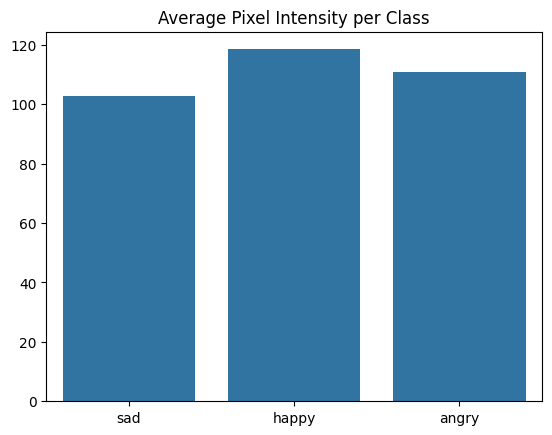

In [12]:
# Example: Compute average pixel intensity for each category
avg_pixel_values = []

for category in categories:
    folder = os.path.join(train_dir, category)
    category_pixels = []
    for img_file in os.listdir(folder):
        img = load_img(os.path.join(folder, img_file), target_size=(224, 224))
        img_array = img_to_array(img)
        category_pixels.append(np.mean(img_array))
    avg_pixel_values.append(np.mean(category_pixels))

# Plot average pixel intensities
sns.barplot(x=categories, y=avg_pixel_values)
plt.title('Average Pixel Intensity per Class')
plt.show()

# Preprocess the data

In [13]:
# Define the image size for MobileNetV2
img_size = (224, 224)

# Step 1: Prepare the ImageDataGenerator for training data with normalization and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=30,  # Random rotations
    width_shift_range=0.2,  # Random horizontal shifts
    height_shift_range=0.2,  # Random vertical shifts
    shear_range=0.2,  # Random shearing
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'  # Fill mode for empty pixels after transformations
)

# Step 2: Prepare ImageDataGenerator for testing data (only normalization)
test_datagen = ImageDataGenerator(rescale=1./255)

# Step 3: Load the datasets using flow_from_directory
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Directory containing the train data
    target_size=img_size,  # Resize images to 224x224
    batch_size=32,  # Number of images to process at a time
    class_mode='categorical',  # Multi-class classification (sad, happy, angry)
    shuffle=True  # Shuffle the data
)

test_generator = test_datagen.flow_from_directory(
    test_dir,  # Directory containing the test data
    target_size=img_size,  # Resize images to 224x224
    batch_size=32,  # Number of images to process at a time
    class_mode='categorical',  # Multi-class classification
    shuffle=False  # Don't shuffle test data
)

Found 6799 images belonging to 3 classes.
Found 2278 images belonging to 3 classes.


# MobileNetV2 model Creation

In [18]:
# Load MobileNetV2 with pre-trained weights (from ImageNet)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model to prevent retraining of pre-trained weights
base_model.trainable = False

# Add custom layers on top of MobileNetV2 for your classification task
model = models.Sequential([
    base_model,  # Add the MobileNetV2 base model
    layers.GlobalAveragePooling2D(),  # Pool the output from the base model
    layers.Dense(128, activation='relu'),  # Fully connected layer with 128 neurons
    layers.Dense(3, activation='softmax')  # Output layer with 3 classes (sad, happy, angry)
])

# Verify the model architecture and shapes by printing the model summary
model.build((None, 224, 224, 3))  # Explicitly build the model with input shape
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Compiling the Model

In [19]:
model.compile(
    optimizer='adam',  # Adam optimizer is a good choice for many tasks
    loss='categorical_crossentropy',  # Categorical crossentropy for multi-class classification
    metrics=['accuracy']  # Track accuracy during training
)

## Fitting the Model

In [21]:
# Define data generators
train_data = train_datagen.flow_from_directory(
    train_dir,  # Directory where the training data is stored
    target_size=(224, 224),  # Resize all images to 224x224 for MobileNetV2
    batch_size=32,  # Number of images per batch
    class_mode='categorical'  # Use 'categorical' since it's multi-class classification
)

test_data = test_datagen.flow_from_directory(
    test_dir,  # Directory where the test data is stored
    target_size=(224, 224),  # Resize all images to 224x224 for MobileNetV2
    batch_size=32,  # Number of images per batch
    class_mode='categorical'  # Use 'categorical' for multi-class classification
)

Found 6799 images belonging to 3 classes.
Found 2278 images belonging to 3 classes.


In [22]:
history = model.fit(
    train_data,
    epochs=10,  # You can adjust this based on your data and computational resources
    validation_data=test_data
)

Epoch 1/10


C:\Users\sehaj\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


213/213 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - accuracy: 0.5487 - loss: 0.9828 - val_accuracy: 0.6457 - val_loss: 0.8001
Epoch 2/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 196s 915ms/step - accuracy: 0.6492 - loss: 0.7850 - val_accuracy: 0.6747 - val_loss: 0.7652
Epoch 3/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 196s 914ms/step - accuracy: 0.6835 - loss: 0.7159 - val_accuracy: 0.6874 - val_loss: 0.7245
Epoch 4/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 196s 913ms/step - accuracy: 0.6968 - loss: 0.6862 - val_accuracy: 0.7112 - val_loss: 0.6754
Epoch 5/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 196s 914ms/step - accuracy: 0.7180 - loss: 0.6518 - val_accuracy: 0.7063 - val_loss: 0.6623
Epoch 6/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 243s 1s/step - accuracy: 0.7044 - loss: 0.6679 - val_accuracy: 0.7182 - val_loss: 0.6676
Epoch 7/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - accuracy: 0.7320 - loss: 0.6192 - val_accuracy: 0.7050 - val_loss: 0.6658
Epoch 8/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - accuracy: 0.7239 - loss: 0.6331 - val_acc

# Plotting the Results

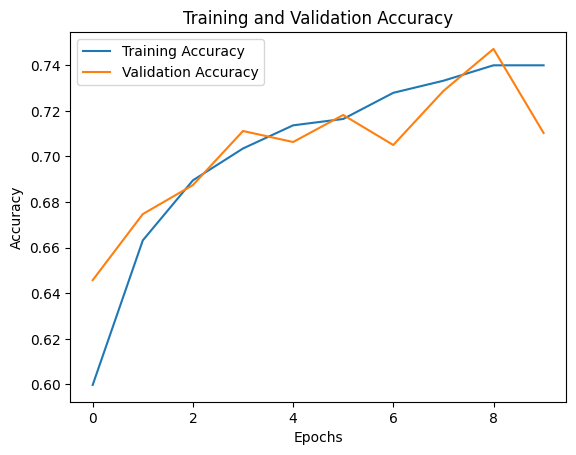

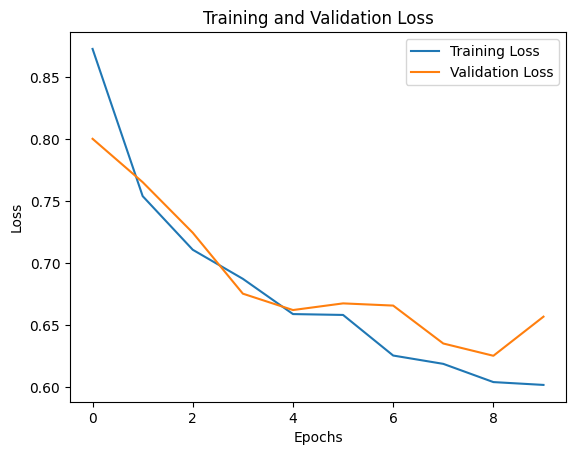

In [23]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion matrix and Classification Report

72/72 ━━━━━━━━━━━━━━━━━━━━ 54s 718ms/step


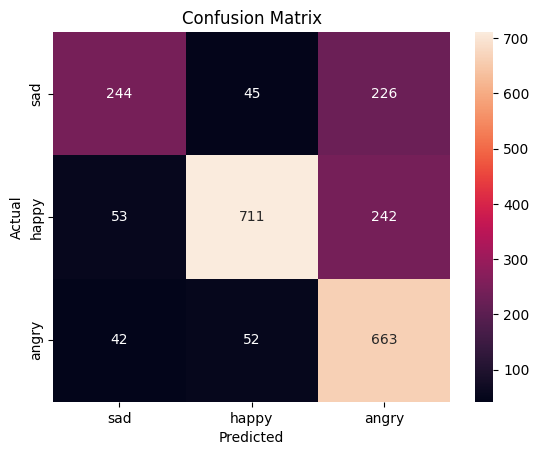

Classification Report:
              precision    recall  f1-score   support

         sad       0.72      0.47      0.57       515
       happy       0.88      0.71      0.78      1006
       angry       0.59      0.88      0.70       757

    accuracy                           0.71      2278
   macro avg       0.73      0.69      0.69      2278
weighted avg       0.75      0.71      0.71      2278

Accuracy: 0.71
Precision: 0.75
Recall: 0.71
F1 Score: 0.71


In [24]:
# Predictions
test_generator.reset()
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Metrics
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=categories))

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Model Testing with Test Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Actual Class: happy
Predicted Class: happy


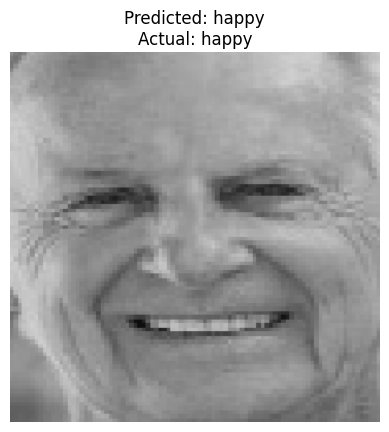

In [39]:
# Define the path to your test images folder
test_folder_path = r"C:\Users\sehaj\Documents\Northeastern classes\Neural Network\human-emotion-detection\Emotions Dataset\test"  # Replace with your test folder path

# List the subfolders (sad, angry, happy)
class_folders = ['sad', 'angry', 'happy']

# Randomly choose a class folder
random_class = random.choice(class_folders)

# Get the list of all jpg images in the chosen folder
image_files = [f for f in os.listdir(os.path.join(test_folder_path, random_class)) if f.endswith('.jpg')]

# Randomly choose an image from the folder
random_image = random.choice(image_files)

# Get the full path to the image
img_path = os.path.join(test_folder_path, random_class, random_image)

# Function to load and preprocess image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    # Load the image with the target size
    img = image.load_img(img_path, target_size=target_size)
    
    # Convert the image to an array
    img_array = image.img_to_array(img)
    
    # Expand dimensions to match the model's input shape (batch size of 1)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Normalize the pixel values to [0, 1]
    img_array = img_array / 255.0
    
    return img_array

# Load and preprocess the image
img_array = load_and_preprocess_image(img_path)

# Make predictions
predictions = model.predict(img_array)

# Get the predicted class
predicted_class = np.argmax(predictions, axis=1)

# Get the class labels (e.g., sad, happy, angry)
class_labels = ['sad', 'happy', 'angry']
predicted_label = class_labels[predicted_class[0]]

# Display the actual and predicted class
print(f"Actual Class: {random_class}")
print(f"Predicted Class: {predicted_label}")

# Display the image
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.title(f"Predicted: {predicted_label}\nActual: {random_class}")
plt.axis('off')  # Remove axes
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Actual Class: sad
Predicted Class: angry


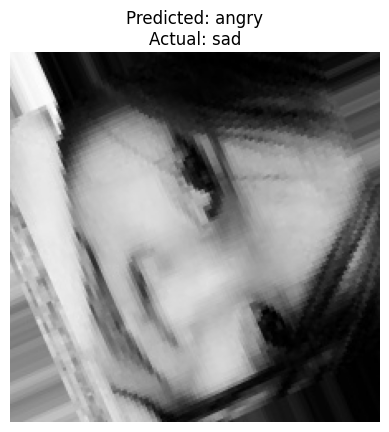

In [40]:
# Define the path to your test images folder
test_folder_path = r"C:\Users\sehaj\Documents\Northeastern classes\Neural Network\human-emotion-detection\Emotions Dataset\test"  # Replace with your test folder path

# List the subfolders (sad, angry, happy)
class_folders = ['sad', 'angry', 'happy']

# Randomly choose a class folder
random_class = random.choice(class_folders)

# Get the list of all jpg images in the chosen folder
image_files = [f for f in os.listdir(os.path.join(test_folder_path, random_class)) if f.endswith('.jpg')]

# Randomly choose an image from the folder
random_image = random.choice(image_files)

# Get the full path to the image
img_path = os.path.join(test_folder_path, random_class, random_image)

# Function to load and preprocess image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    # Load the image with the target size
    img = image.load_img(img_path, target_size=target_size)
    
    # Convert the image to an array
    img_array = image.img_to_array(img)
    
    # Expand dimensions to match the model's input shape (batch size of 1)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Normalize the pixel values to [0, 1]
    img_array = img_array / 255.0
    
    return img_array

# Load and preprocess the image
img_array = load_and_preprocess_image(img_path)

# Make predictions
predictions = model.predict(img_array)

# Get the predicted class
predicted_class = np.argmax(predictions, axis=1)

# Get the class labels (e.g., sad, happy, angry)
class_labels = ['sad', 'happy', 'angry']
predicted_label = class_labels[predicted_class[0]]

# Display the actual and predicted class
print(f"Actual Class: {random_class}")
print(f"Predicted Class: {predicted_label}")

# Display the image
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.title(f"Predicted: {predicted_label}\nActual: {random_class}")
plt.axis('off')  # Remove axes
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Prediction 1:
  Actual Class: angry
  Predicted Class: angry


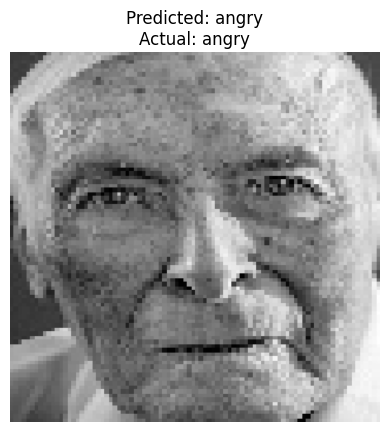

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Prediction 2:
  Actual Class: sad
  Predicted Class: angry


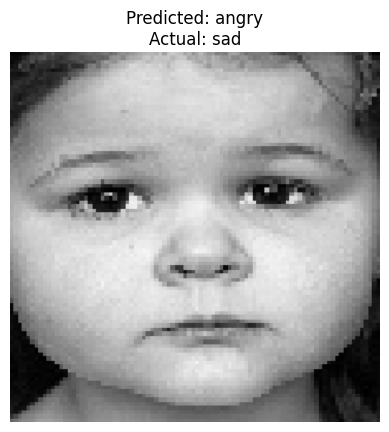

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Prediction 3:
  Actual Class: angry
  Predicted Class: happy


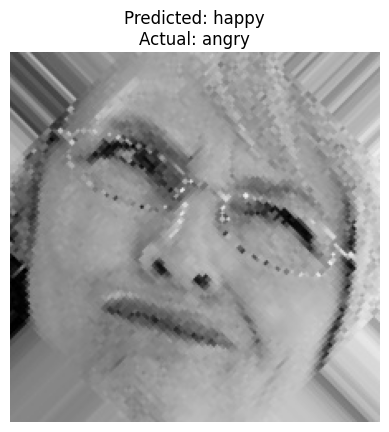

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Prediction 4:
  Actual Class: sad
  Predicted Class: angry


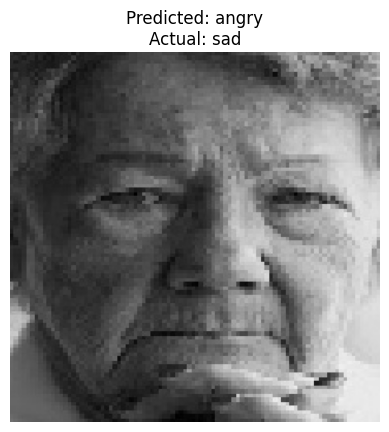

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Prediction 5:
  Actual Class: happy
  Predicted Class: happy


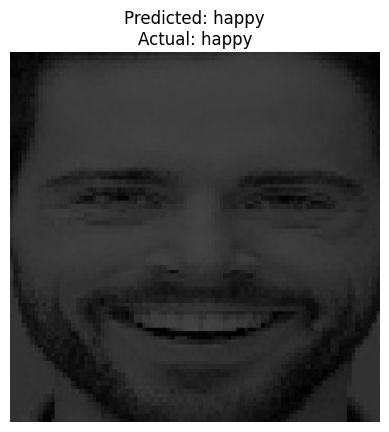

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Prediction 6:
  Actual Class: happy
  Predicted Class: happy


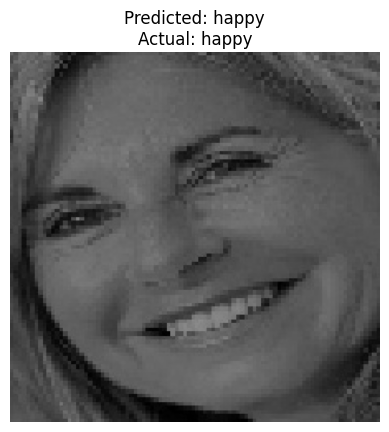

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediction 7:
  Actual Class: happy
  Predicted Class: happy


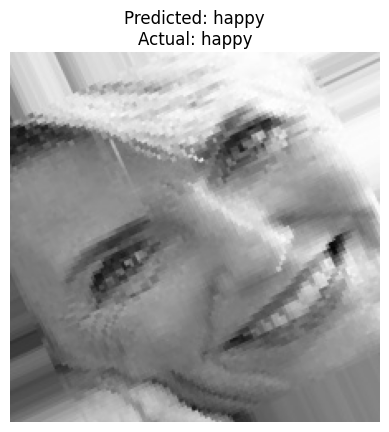

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Prediction 8:
  Actual Class: happy
  Predicted Class: happy


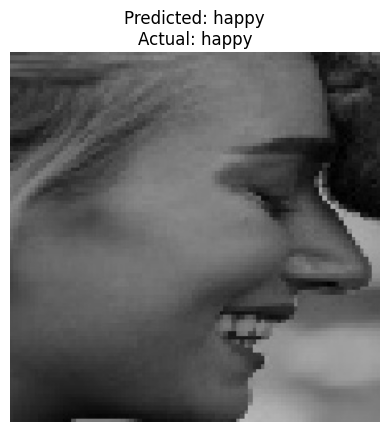

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Prediction 9:
  Actual Class: sad
  Predicted Class: angry


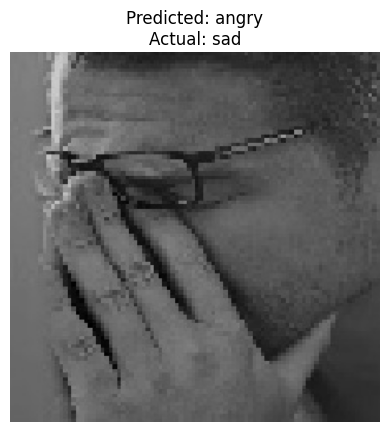

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Prediction 10:
  Actual Class: sad
  Predicted Class: angry


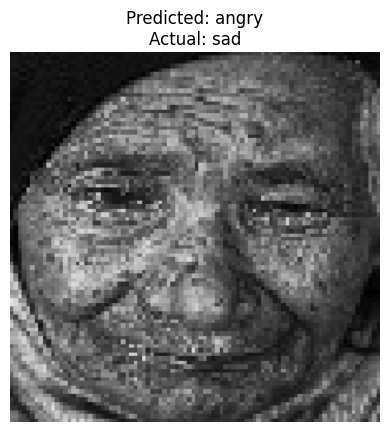

In [43]:

test_folder_path = r"C:\Users\sehaj\Documents\Northeastern classes\Neural Network\human-emotion-detection\Emotions Dataset\test"  # Replace with your test folder path

# List the subfolders (sad, angry, happy)
class_folders = ['sad', 'angry', 'happy']

# Function to load and preprocess an image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    # Load the image with the target size
    img = image.load_img(img_path, target_size=target_size)
    
    # Convert the image to an array
    img_array = image.img_to_array(img)
    
    # Expand dimensions to match the model's input shape (batch size of 1)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Normalize the pixel values to [0, 1]
    img_array = img_array / 255.0
    
    return img_array

# Make 10 predictions
for i in range(10):
    # Randomly choose a class folder
    random_class = random.choice(class_folders)

    # Get the list of all jpg images in the chosen folder
    image_files = [f for f in os.listdir(os.path.join(test_folder_path, random_class)) if f.endswith('.jpg')]

    # Randomly choose an image from the folder
    random_image = random.choice(image_files)

    # Get the full path to the image
    img_path = os.path.join(test_folder_path, random_class, random_image)

    # Load and preprocess the image
    img_array = load_and_preprocess_image(img_path)

    # Make predictions
    predictions = model.predict(img_array)

    # Get the predicted class
    predicted_class = np.argmax(predictions, axis=1)

    # Get the class labels (e.g., sad, happy, angry)
    class_labels = ['sad', 'happy', 'angry']
    predicted_label = class_labels[predicted_class[0]]

    # Display the actual and predicted class
    print(f"Prediction {i+1}:")
    print(f"  Actual Class: {random_class}")
    print(f"  Predicted Class: {predicted_label}")

    # Display the image
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}\nActual: {random_class}")
    plt.axis('off')  # Remove axes
    plt.show()
